# Quick Draw Diffusion Model
This project trains a class-conditioned diffusion model on samples from the [Google QuickDraw Dataset](https://github.com/googlecreativelab/quickdraw-dataset). The training loop and sample code is referenced from the [huggingface introduction to diffusion models notebook](https://huggingface.co/learn/diffusion-course/en/unit1/2).

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.1/873.1 kB 27.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 

In [3]:
!unzip /content/quick_draw_dataset.zip -d /content/quick_draw_dataset/

Archive:  /content/quick_draw_dataset.zip
replace /content/quick_draw_dataset/content/quick_draw_dataset/state.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/quick_draw_dataset/content/quick_draw_dataset/state.json  
replace /content/quick_draw_dataset/content/quick_draw_dataset/data-00000-of-00001.arrow? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/quick_draw_dataset/content/quick_draw_dataset/data-00000-of-00001.arrow  
replace /content/quick_draw_dataset/content/quick_draw_dataset/dataset_info.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/quick_draw_dataset/content/quick_draw_dataset/dataset_info.json  


In [5]:
from datasets import load_from_disk

# load dataset

dataset = load_from_disk("/content/quick_draw_dataset")

In [36]:
dataset.info
# The dataset has the classes ['banana', 'apple', 'bday_cake', 'broom', 'broccoli'] and each image is 28x28. There are a total of 5000 images

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Array2D(shape=(28, 28), dtype='uint8'), 'label': ClassLabel(names=['banana', 'apple', 'bday_cake', 'broom', 'broccoli'])}, post_processed=None, supervised_keys=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

In [7]:
import torchvision
import torch
from datasets import Dataset, Features, Array2D
from datasets import load_dataset
from torchvision import transforms
from PIL import Image



image_size = 32
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Pad(padding=2, fill=255), # Make images 32x32
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

def transform(example):
    images = []
    labels = []
    for i in range(len(example["image"])):
        images.append(preprocess(Image.fromarray(np.array(example["image"][i], dtype=np.uint8), mode="L")))
        labels.append(example["label"][i])

    return {"images": images, "labels": labels}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import numpy as np

/tmp/ipython-input-1488311122.py:33: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  images.append(preprocess(Image.fromarray(np.array(example["image"][i], dtype=np.uint8), mode="L")))


tensor([2, 2, 2, 2, 3, 4, 1, 0], device='cuda:0')


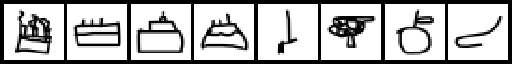

In [10]:
# see some samples from the dataset. As we can see, the images for each class vary greatly since they are doodles drawn by humans

xb = next(iter(train_dataloader))
print(xb["labels"].to(device)[:8])
show_images(xb["images"].to(device)[:8]).resize((8 * 64, 64), resample=Image.NEAREST)

In [15]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=2,  # the number of input channels, 1 channel for images + 1 for class label
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [37]:
import torch
import torch.nn.functional as F

#define a function that takes the batch of class label torch.tensor(1) and expands it to the image size and concats it with the image batch
def concat(x, l):
  labels = l[:, None, None, None].expand(-1, -1, 32, 32)
  return torch.cat([x, labels], dim=1)

In [21]:
# making sure the concat works on a small sample

l = torch.tensor([2, 4, 2, 2, 3, 0, 4, 4])
x = torch.randn(8, 1, 32, 32)
concat(x, l).shape

torch.Size([8, 2, 32, 32])

In [24]:
from diffusers import DDPMScheduler
import torch.nn.functional as F


# Set the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1500, beta_schedule="squaredcos_cap_v2")

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(50):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Concat the labels onto the noisy images - the shape will go from [8, 1, 32, 32] to [8, 2, 32, 32]
        labelled_images = concat(noisy_images, batch["labels"].to(device))

        # Get the model prediction
        noise_pred = model(labelled_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/tmp/ipython-input-1488311122.py:33: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  images.append(preprocess(Image.fromarray(np.array(example["image"][i], dtype=np.uint8), mode="L")))


Epoch:5, loss: 0.08071856974046442
Epoch:10, loss: 0.06126206184301195
Epoch:15, loss: 0.05582022605628907
Epoch:20, loss: 0.05207749319416058
Epoch:25, loss: 0.0489132267104674
Epoch:30, loss: 0.047987582704311686
Epoch:35, loss: 0.04744036368365529
Epoch:40, loss: 0.045699644126469575
Epoch:45, loss: 0.04425106650289101
Epoch:50, loss: 0.04379821993127654


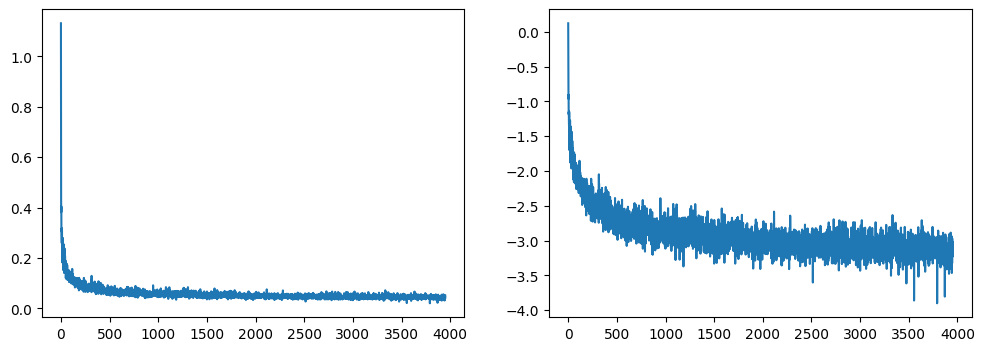

In [38]:
import matplotlib.pyplot as plt

# plot the losses

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

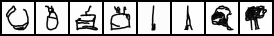

In [34]:
# Random starting point (8 random images):
sample = torch.randn(8, 1, 32, 32).to(device)
labels = torch.tensor([0, 1, 2, 2, 3, 3, 4, 4]).to(device) # lets choose random labels to pass in with each image

int_medS = [] # container to hold intermediate samples - this provieds insight into the denoising process

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(concat(sample, labels), t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample
    if i % 100 == 0:
        int_medS.append(sample)

show_images(sample)

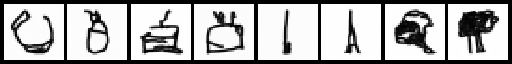

In [35]:
show_images(sample).resize((8 * 64, 64), resample=Image.NEAREST) # see the images - not bad!
# the labels: ['banana', 'apple', 'bday_cake', 'bday_cake', 'broom', 'broom', 'broccoli', 'broccoli']

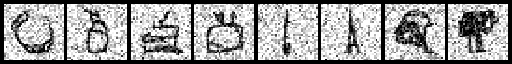

In [41]:
# see what the images looked like halfway during the diffusion process
show_images(int_medS[10]).resize((8 * 64, 64), resample=Image.NEAREST)